# EDA — Credit Risk (BNPL) Dataset

This notebook performs exploratory data analysis to understand the dataset structure, distributions, missing data, and initial signals for feature engineering.  
Each section contains a short explanation and the code used to produce the result.

In [2]:
# Standard imports and display options
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Notebook display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
sns.set_style("whitegrid")

# Path to raw data - update filename if needed
DATA_PATH = "../data/raw/data.csv"

# Load dataset
df = pd.read_csv(DATA_PATH, parse_dates=['TransactionStartTime'], low_memory=False)
print("Loaded dataset with shape:", df.shape)


Loaded dataset with shape: (95662, 16)


## 1. Dataset Overview

Check the number of rows and columns, list column names and data types, and display first rows to get a sense of raw fields.


In [3]:
# Basic info
print("Rows, Columns:", df.shape)
print("\nColumn names and data types:\n")
print(df.dtypes)

# Show first 5 rows
display(df.head())

# Quick check for unique identifiers
for col in ['TransactionId', 'AccountId', 'CustomerId', 'SubscriptionId', 'BatchId']:
    if col in df.columns:
        print(f"{col}: unique={df[col].nunique()}, missing={df[col].isna().sum()}")


Rows, Columns: (95662, 16)

Column names and data types:

TransactionId                        object
BatchId                              object
AccountId                            object
SubscriptionId                       object
CustomerId                           object
CurrencyCode                         object
CountryCode                           int64
ProviderId                           object
ProductId                            object
ProductCategory                      object
ChannelId                            object
Amount                              float64
Value                                 int64
TransactionStartTime    datetime64[ns, UTC]
PricingStrategy                       int64
FraudResult                           int64
dtype: object


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0


TransactionId: unique=95662, missing=0
AccountId: unique=3633, missing=0
CustomerId: unique=3742, missing=0
SubscriptionId: unique=3627, missing=0
BatchId: unique=94809, missing=0


## 2. Summary Statistics (Numerical Features)

Look at mean, median, standard deviation, min, max and quartiles for numeric features. This helps identify skewness and scale issues.


In [4]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical columns:", num_cols)

# Summary stats
display(df[num_cols].describe().T)

# Additional skewness and kurtosis
skew_kurt = pd.DataFrame({
    'skew': df[num_cols].skew(),
    'kurtosis': df[num_cols].kurtosis(),
    'nan_count': df[num_cols].isna().sum()
}).sort_values('skew', ascending=False)
display(skew_kurt)


Numerical columns: ['CountryCode', 'Amount', 'Value', 'PricingStrategy', 'FraudResult']


,count,mean,std,min,25%,50%,75%,max
CountryCode,95662.0,256.000000,0.000000,256.0,256.0,256.0,256.0,256.0
Amount,95662.0,6717.846433,123306.797164,-1000000.0,-50.0,1000.0,2800.0,9880000.0
Value,95662.0,9900.583941,123122.087776,2.0,275.0,1000.0,5000.0,9880000.0
PricingStrategy,95662.0,2.255974,0.732924,0.0,2.0,2.0,2.0,4.0
FraudResult,95662.0,0.002018,0.044872,0.0,0.0,0.0,0.0,1.0


,skew,kurtosis,nan_count
Value,51.291086,3378.069274,0
Amount,51.098490,3363.127739,0
FraudResult,22.196295,490.685762,0
PricingStrategy,1.659057,2.087534,0
CountryCode,0.000000,0.000000,0


## 3. Distribution of Key Numerical Features

Plot histograms and log-histograms for highly skewed features (e.g., Amount, Value). This reveals long tails and outliers.


c:\Users\derej\Desktop\Kifya\bnpl_risk\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


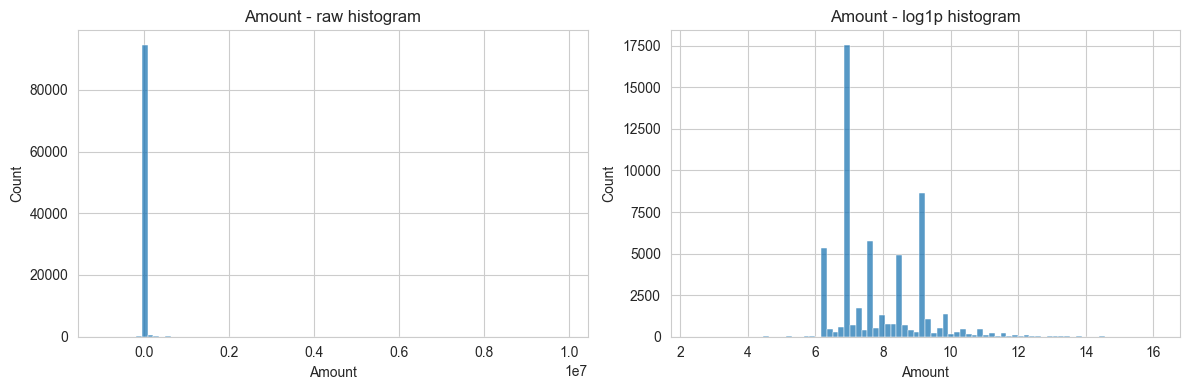

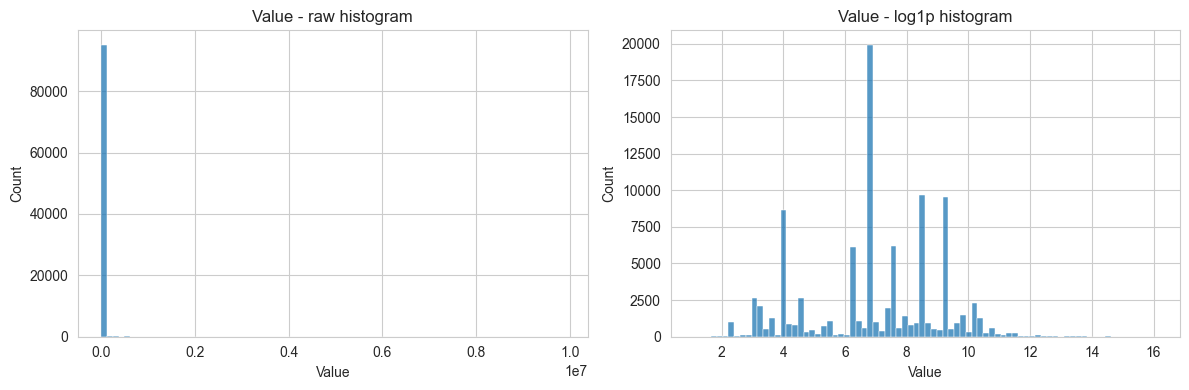

In [5]:
# choose a few important numeric fields; update names if necessary
candidates = [c for c in ['Amount', 'Value'] if c in df.columns]

for col in candidates:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(df[col].dropna(), bins=80, kde=False)
    plt.title(f'{col} - raw histogram')
    
    plt.subplot(1,2,2)
    sns.histplot(np.log1p(df[col].dropna()), bins=80, kde=False)
    plt.title(f'{col} - log1p histogram')
    plt.tight_layout()
    plt.show()


## 4. Distribution of Categorical Features

Examine frequency counts for categorical columns to identify dominant categories and rare levels (which may need grouping).


In [6]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols = [c for c in cat_cols if c not in ['TransactionStartTime']]  # Just in case
print("Categorical columns:", cat_cols)

# Show top counts for each categorical column
for col in cat_cols:
    print(f"\n--- {col} (unique={df[col].nunique()}) ---")
    display(df[col].value_counts(dropna=False).head(20))


Categorical columns: ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId']

--- TransactionId (unique=95662) ---


TransactionId
TransactionId_76871     1
TransactionId_73770     1
TransactionId_26203     1
TransactionId_380       1
TransactionId_28195     1
TransactionId_23223     1
TransactionId_118063    1
TransactionId_100640    1
TransactionId_51905     1
TransactionId_130161    1
TransactionId_51800     1
TransactionId_33857     1
TransactionId_94963     1
TransactionId_104687    1
TransactionId_86903     1
TransactionId_118831    1
TransactionId_122975    1
TransactionId_98367     1
TransactionId_64044     1
TransactionId_119821    1
Name: count, dtype: int64


--- BatchId (unique=94809) ---


BatchId
BatchId_67019     28
BatchId_51870     16
BatchId_113893    14
BatchId_127204    12
BatchId_116835    10
BatchId_88001      9
BatchId_49408      7
BatchId_110084     7
BatchId_34879      6
BatchId_86880      6
BatchId_4233       6
BatchId_66085      6
BatchId_48890      6
BatchId_107049     6
BatchId_22960      6
BatchId_92882      6
BatchId_25522      5
BatchId_62435      5
BatchId_60536      5
BatchId_84709      5
Name: count, dtype: int64


--- AccountId (unique=3633) ---


AccountId
AccountId_4841    30893
AccountId_4249     4457
AccountId_4840     1738
AccountId_3206     1105
AccountId_318      1070
AccountId_10        965
AccountId_3595      465
AccountId_751       411
AccountId_2648      359
AccountId_2314      356
AccountId_1346      350
AccountId_2123      318
AccountId_476       315
AccountId_2659      310
AccountId_1301      309
AccountId_2203      296
AccountId_2990      294
AccountId_1955      270
AccountId_3476      268
AccountId_2783      266
Name: count, dtype: int64


--- SubscriptionId (unique=3627) ---


SubscriptionId
SubscriptionId_3829    32630
SubscriptionId_4429     4457
SubscriptionId_1372     1105
SubscriptionId_3087     1070
SubscriptionId_4346      965
SubscriptionId_1749      465
SubscriptionId_919       411
SubscriptionId_1311      359
SubscriptionId_4722      356
SubscriptionId_652       350
SubscriptionId_1456      318
SubscriptionId_2272      315
SubscriptionId_3327      310
SubscriptionId_586       309
SubscriptionId_2113      296
SubscriptionId_216       294
SubscriptionId_4208      270
SubscriptionId_2958      268
SubscriptionId_3524      266
SubscriptionId_2644      262
Name: count, dtype: int64


--- CustomerId (unique=3742) ---


CustomerId
CustomerId_7343    4091
CustomerId_3634    2085
CustomerId_647     1869
CustomerId_1096     784
CustomerId_4033     778
CustomerId_3066     612
CustomerId_2528     610
CustomerId_2728     586
CustomerId_3078     573
CustomerId_806      557
CustomerId_2612     532
CustomerId_1709     524
CustomerId_2349     484
CustomerId_3944     483
CustomerId_1663     480
CustomerId_3415     471
CustomerId_4840     434
CustomerId_682      428
CustomerId_3204     426
CustomerId_3912     425
Name: count, dtype: int64


--- CurrencyCode (unique=1) ---


CurrencyCode
UGX    95662
Name: count, dtype: int64


--- ProviderId (unique=6) ---


ProviderId
ProviderId_4    38189
ProviderId_6    34186
ProviderId_5    14542
ProviderId_1     5643
ProviderId_3     3084
ProviderId_2       18
Name: count, dtype: int64


--- ProductId (unique=23) ---


ProductId
ProductId_6     32635
ProductId_3     24344
ProductId_10    15384
ProductId_15    11964
ProductId_1      2885
ProductId_4      2403
ProductId_21     1512
ProductId_11     1377
ProductId_19      965
ProductId_14      789
ProductId_13      296
ProductId_2       236
ProductId_20      216
ProductId_8       197
ProductId_24      175
ProductId_22      112
ProductId_7        86
ProductId_27       31
ProductId_5        25
ProductId_9        17
Name: count, dtype: int64


--- ProductCategory (unique=9) ---


ProductCategory
financial_services    45405
airtime               45027
utility_bill           1920
data_bundles           1613
tv                     1279
ticket                  216
movies                  175
transport                25
other                     2
Name: count, dtype: int64


--- ChannelId (unique=4) ---


ChannelId
ChannelId_3    56935
ChannelId_2    37141
ChannelId_5     1048
ChannelId_1      538
Name: count, dtype: int64

## 5. Correlations Between Numerical Features

Compute pairwise correlations and show a heatmap. This helps to find strongly related features and potential multicollinearity.


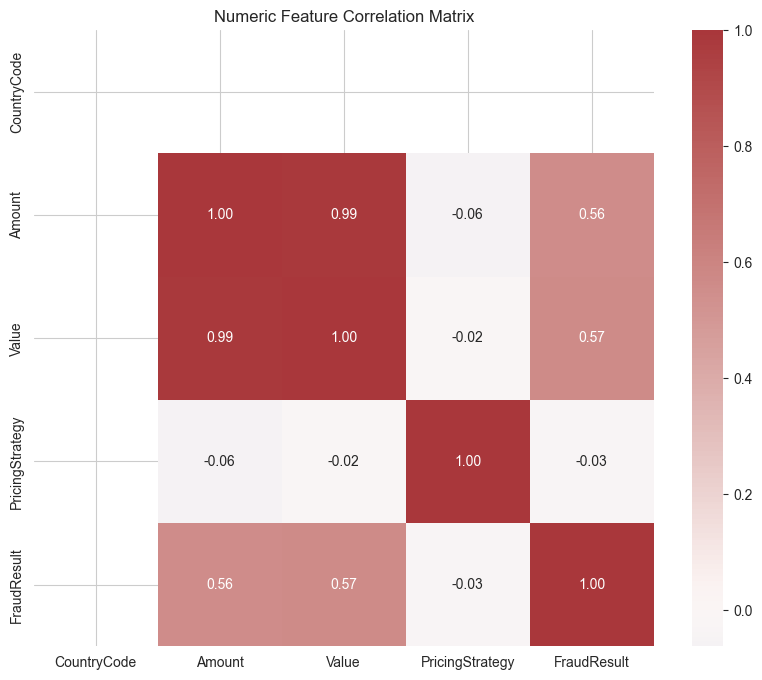

Highly correlated pairs (abs>0.7): [('Amount', 'Value')]


In [7]:
# Correlation matrix for numeric features
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title("Numeric Feature Correlation Matrix")
plt.show()

# Print pairs with high absolute correlation (threshold = 0.7)
high_corr = []
threshold = 0.7
for i in corr.columns:
    for j in corr.columns:
        if i != j and abs(corr.loc[i, j]) > threshold:
            pair = tuple(sorted((i, j)))
            if pair not in high_corr:
                high_corr.append(pair)
print("Highly correlated pairs (abs>0.7):", high_corr)


## 6. Missing Values

Identify columns with missing values and their proportions. Decide which columns may require imputation, removal, or special handling.


In [9]:
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(df)).round(4) * 100
missing_table = pd.concat([missing, missing_pct], axis=1)
missing_table.columns = ['missing_count', 'missing_percent']
display(missing_table[missing_table['missing_count'] > 0])

# Visualize missingness for top columns with missing values
top_missing = missing_table[missing_table['missing_count'] > 0].head(15).index.tolist()
if top_missing:
    plt.figure(figsize=(12,6))
    sns.heatmap(df[top_missing].isnull(), cbar=False)
    plt.title("Missing value matrix (top columns)")
    plt.show()


,missing_count,missing_percent


## 7. Outlier Detection

Use boxplots and percentile summaries to spot extreme values that may require capping or transformation.


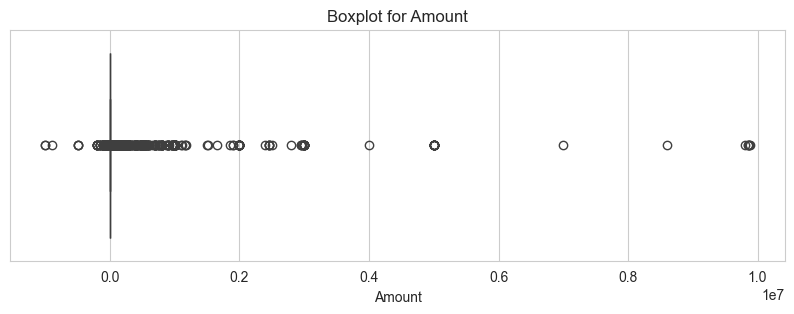


Percentiles for Amount:
 0.00   -1000000.0
0.01     -30000.0
0.05      -5000.0
0.25        -50.0
0.50       1000.0
0.75       2800.0
0.95      14500.0
0.99      80000.0
1.00    9880000.0
Name: Amount, dtype: float64


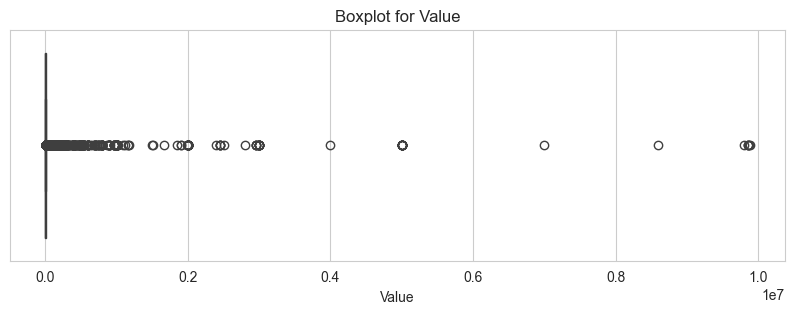


Percentiles for Value:
 0.00          2.0
0.01         10.0
0.05         25.0
0.25        275.0
0.50       1000.0
0.75       5000.0
0.95      25000.0
0.99      90000.0
1.00    9880000.0
Name: Value, dtype: float64


In [10]:
for col in candidates:
    plt.figure(figsize=(10,3))
    sns.boxplot(x=df[col].dropna())
    plt.title(f'Boxplot for {col}')
    plt.show()
    
    # Print percentiles
    pct = df[col].quantile([0, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 1.0])
    print(f"\nPercentiles for {col}:\n", pct)


## 8. Time-Based Feature Exploration

Extract transaction hour, weekday, and month to find temporal patterns. Also compute a simple recency per customer (time since last transaction) for initial RFM insight.


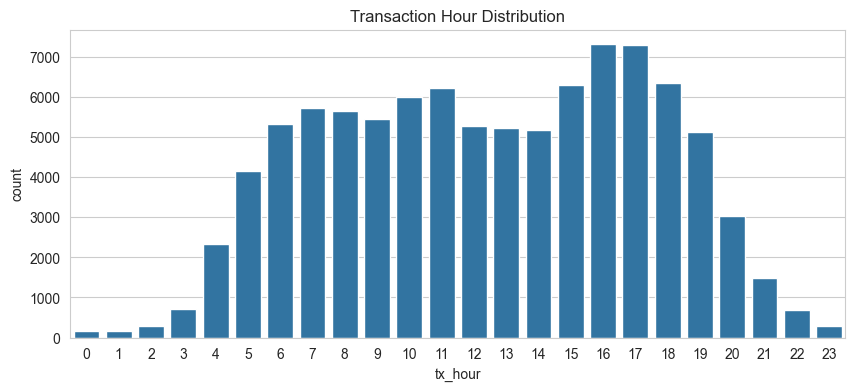

count    3742.000000
mean       31.461251
std        27.118932
min         1.000000
25%         6.000000
50%        25.000000
75%        54.000000
max        91.000000
Name: recency_days, dtype: float64

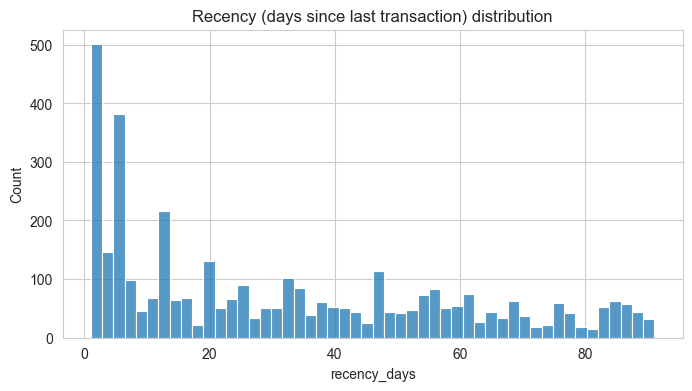

In [11]:
# Ensure TransactionStartTime is datetime
if 'TransactionStartTime' in df.columns:
    df['tx_hour'] = df['TransactionStartTime'].dt.hour
    df['tx_day'] = df['TransactionStartTime'].dt.day
    df['tx_month'] = df['TransactionStartTime'].dt.month
    df['tx_weekday'] = df['TransactionStartTime'].dt.weekday
    
    # plot hour distribution
    plt.figure(figsize=(10,4))
    sns.countplot(x='tx_hour', data=df, order=sorted(df['tx_hour'].dropna().unique()))
    plt.title('Transaction Hour Distribution')
    plt.show()
    
    # sample recency: compute last transaction date per customer and days since snapshot
    snapshot_date = df['TransactionStartTime'].max() + pd.Timedelta(days=1)
    last_tx = df.groupby('CustomerId')['TransactionStartTime'].max().rename('last_tx')
    recency = (snapshot_date - last_tx).dt.days.rename('recency_days')
    recency.describe().round(1)
    display(recency.describe())
    
    plt.figure(figsize=(8,4))
    sns.histplot(recency, bins=50)
    plt.title('Recency (days since last transaction) distribution')
    plt.show()
else:
    print("TransactionStartTime column not found; skip time features.")


## 9. RFM Aggregation (Recency, Frequency, Monetary)

Create basic RFM metrics per CustomerId. These aggregates will be used to create the proxy target via clustering in Task-4.


,count,mean,std,min,25%,50%,75%,max
recency_days,3742.0,31.461251,2.711893e+01,1.0,6.0000,25.0,54.00,91.0
frequency,3742.0,25.564404,9.692960e+01,1.0,2.0000,7.0,20.00,4091.0
monetary,3742.0,171737.740647,2.717305e+06,-104900000.0,4077.4375,20000.0,79967.75,83451240.0


c:\Users\derej\Desktop\Kifya\bnpl_risk\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


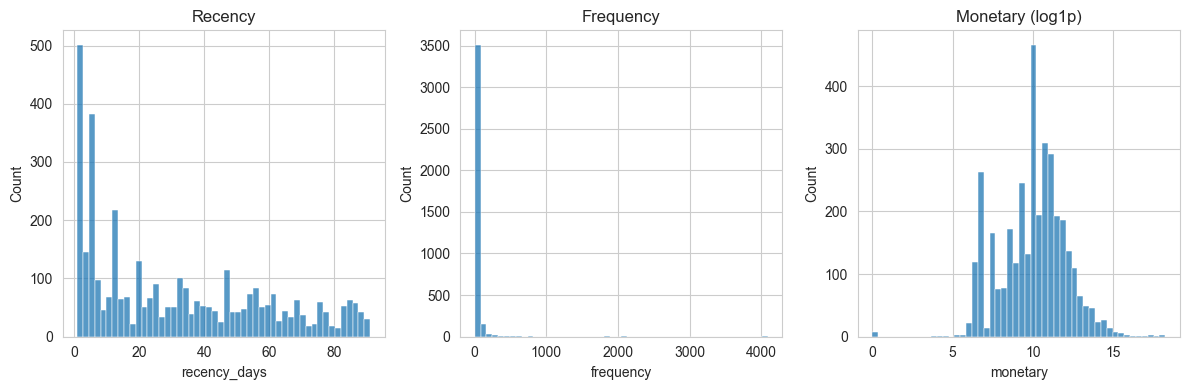

In [12]:
# Basic RFM calculation
snapshot_date = df['TransactionStartTime'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerId').agg(
    frequency=('TransactionId', 'count'),
    monetary=('Amount', 'sum'),
    last_tx=('TransactionStartTime', 'max')
).reset_index()

rfm['recency_days'] = (snapshot_date - rfm['last_tx']).dt.days
rfm = rfm[['CustomerId', 'recency_days', 'frequency', 'monetary']]
display(rfm.describe().T)

# Quick visualization
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot(rfm['recency_days'], bins=50)
plt.title('Recency')
plt.subplot(1,3,2)
sns.histplot(rfm['frequency'], bins=50)
plt.title('Frequency')
plt.subplot(1,3,3)
sns.histplot(np.log1p(rfm['monetary']), bins=50)
plt.title('Monetary (log1p)')
plt.tight_layout()
plt.show()
